### Noms et Prénoms du binome:

CILLEROS Victor
JEAN jérémy (caramel)
---

# TP en Watermarking - TP2

---

## Patrick Bas, CNRS, CRIStAL

---


 

## Tatouage par également de spectre et attaques de sécurité

### 2.1 Notations et rappels:

Les notations sont identiques à celles vues en cours. Le procédé d'insertion est le schéma par étalement de spectre vu en cours.

* X = matrice de $N_{i}$ vecteurs originaux de taille $N_{v}$ ($N_{i}$ colonnes, $N_{v}$ lignes). $N_{i}$ représente par exemple le nombre de contenu traités, et $N_{v}$ le nombre de composantes tatouées par contenu. **Note**: chaque colonne de X peut par exemple représenter des composantes d'une image.
* $N_{o}$ représente le nombre de contenus tatoués observés par l'adversaire et utilisés pour construire son attaque
* $N_{i}$ représente le nombre de contenus tatoués utilisés pour calculer pratiquement le taux d'erreur (voir BER)
* Y = matrice de contenus tatoués
* Z = matrice de contenus tatoués et perturbés
* k clé secrète de norme unitaire
* $m_{1}$: bit inséré, converti en +1, -1 
* $\alpha$: paramètre de distorsion
* BER: Bit Error Rate, taux d'erreur binaire ou encore probabilité d'erreur empirique de décodage
* DWR: « Document to Watermark Ratio » $DWR=10\log_{10}(\sum x_{i}^{2}/\sum w_{i}^{2})$, permet de mesurer la distorsion ($DWR=0$ $\Leftrightarrow$ $\sigma_{X}^{2}=\sigma_{W}^{2}$ ). Permet de mesurer la distortion. Distortion nulle $DWR=\infty$, distortion importante $DWR \rightarrow 0$ 

#### Rappels:
* L'objectif du récepteur et de bien décoder $m_{1}$, possiblement en ayant une distortion qui ne soit pas trop importante
* Ici, les objectifs de l'adversaire sont d'estimer la clé k puis d'effacer le message inséré. Pour s'assurer que l'adversaire a bien réussi à estimer la clé, il calculera la correlation normalisée entre le vecteur k et son estimation.

**N'oubliez pas d'exporter votre TP en html lors de sa remise**



In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from sklearn.decomposition import FastICA

## Scénario 1: Attaque à Messages connus, 1 bit
* Mise en route: Quel est le BER cible de l'adversaire ?
* Mettre en place l'attaque liée à ce scénario
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

In [3]:
Nv = 100 # Size of the vector
Ni = 10000 # Max number of observations

In [117]:
def ber(Y,m,k):#Compute the Bit Error Rate between message m and the extracted message from Y using key k
    c = np.sign(np.dot(Y.T,k.reshape(-1,1)))
    return np.sum(c != m.reshape(-1,1))/float(Y.shape[1])
    

def norm_corr(hatk,k):
    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # Normalize
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) # Compute the Normalised correlation
    return corrN

def do_process(alpha,No):
    
    #print('alpha: ',alpha)
    #print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    #print(k.shape)
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.ones((Ni,1)) #Scenario with Known Messages: generate only ones, to be changed for the WOA attack!!!

    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)

    W = alpha*K

    Y = X + W # perform embedding

    DWR = 10*np.log10(Nv/alpha**2) # Set the Document to Watermark Ratio, in dB

    #print('DWR: ',DWR,' dB')

    cY = np.sign(np.dot(Y.T,k)) # Computation of the decoded 'bits' (here -1 or +1)
    #print('practical bit error rate:')
    #print(np.sum(cY != m1)/np.float(Ni)) 

    Y_obs = Y[:,:No]
    # To Do: implement the attack on No observation, i.e. on Y[:,:No]
    hatk = (1/No)*np.sum([(-1)**(m1[i,0]+1)*Y_obs[:,i] for i in range(No)],axis=0).reshape(-1,1)

    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # We need to Normalize
    
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) # Compute the Normalised correlation
    #print('Normalised correlation between the true key and the estimated key')
    #print(corrN)
    #print(hatk.shape)
    hatk = np.reshape(hatk,(Nv,1))# We need to reshape

    YA = Y - alpha*np.dot(hatk,m1.T) # KMA: perform the removal attack
    #print('practical bit error rate after security attack')
    #print(ber(YA,m1,k))
    #print('\n\n')
    return corrN[0]
    

alpha = 2 # Tune the power of the watermark here

# One example, can be used to draw plots
def history_process(alpha, min_No, max_No, step, show=True):
    historyCorr = []
    assert (max_No-min_No)%step == 0 , f"nombre de step non valide {step}"
    for No in range(min_No,max_No,step):
        historyCorr.append(do_process(alpha,No))
    if show : 
        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyCorr)
        plt.title("Evolution de la corrélation entre la clé estimé et la clé réelle")
        plt.xlabel("Nombre observations")
        plt.ylabel("Corrélation")
        plt.show()

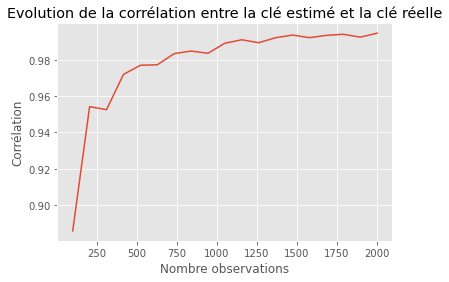

In [13]:
history_process(2,100,2000,100)

On remarque avec la grapique obtenu ci-dessus que la corrélation est d'autant plus important qu'on à d'info au départ (valeur de No).
Avec seulement 2000 observation (à savoir 20% du total) on estime déjà à 99% la clé secrète.

## Scénario 2, Attaque à messages inconnus, 1bit
* Note: la fonction `np.linalg.eig` peut être utilisée pour effectuer une décomposition en valeurs et vecteurs propres.
* Note: pour effacer le message inséré, il conviendra au préalable d'estimer le bit inséré, cela peut se faire via `m_est = np.sign(np.dot(Y.T,hatk))` où `hatk` est la clé estimée
* Mettre en place l'attaque
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

In [14]:
# 2dn scenario, scenario with KMA 
print("**************************************************")
print('2nd Scenario')
print("**************************************************")

def do_process_2(alpha,No):
    
    #print('alpha: ',alpha)
    #print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.sign(np.random.randn(Ni,1)) #Scenario with unknow messages, first bit

    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)

    W = alpha*K

    Y = X + W # perform embedding

    Y_obs = Y[:,:No]
    
    #hatk  : 
    vaP,vectP = np.linalg.eig(Y_obs@Y_obs.T)
    hatk=vectP[:,0].reshape(-1,1)
    #print(f"test norm vecteur propre le plus important : {np.linalg.norm(hatk,2)}")

    corrN = norm_corr(hatk,k)# To ease the writing we use the norm_corr function

    #print('Normalised correlation between the true key and the estimated key')
    #print(corrN)

    #m_est = TO DO
    m_est = (np.sign(Y.T@hatk))

    #YA = TO DO 

    YA = Y - alpha*(hatk@m_est.T)

    #print('bit error rate after security attack')
    ber_2 = ber(YA,m1,k)
    #print()
    #print('\n\n')
    return corrN[0], ber_2

    
alpha = 2 # Tune the power of the watermark here

def history_process_2(alpha, min_No, max_No, step, show=True):
    
    assert (max_No-min_No)%step == 0 , "erreur dans les paramètres"
    if (type(alpha)==int):
        plt.style.use('ggplot')
        plt.figure()
        for a in range(1,alpha):
            historyCorr = []
            historyBer = []
            for No in range(min_No,max_No,step):
                c, b = do_process_2(a,No)
                historyCorr.append(c)
                historyBer.append(b)
            if show :
                plt.plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyBer,label=f"alpha vaut : {a}")
        plt.title("Evolution du ber")
        plt.xlabel("Nombre observations")
        plt.ylabel("Ber")
        plt.legend()
        plt.show()
    else:
        plt.style.use('ggplot')
        plt.figure(figsize=(50,50))
        for a in alpha:
            historyCorr = []
            historyBer = []
            for No in range(min_No,max_No,step):
                c, b = do_process_2(a,No)
                historyCorr.append(c)
                historyBer.append(b)
            if show : 
                plt.plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyBer, label = f"alpha = {round(a,1)}")
        plt.title("Evolution du ber")
        plt.xlabel("Nombre observations")
        plt.ylabel("Ber")
        plt.legend()
        plt.show()

**************************************************
2nd Scenario
**************************************************


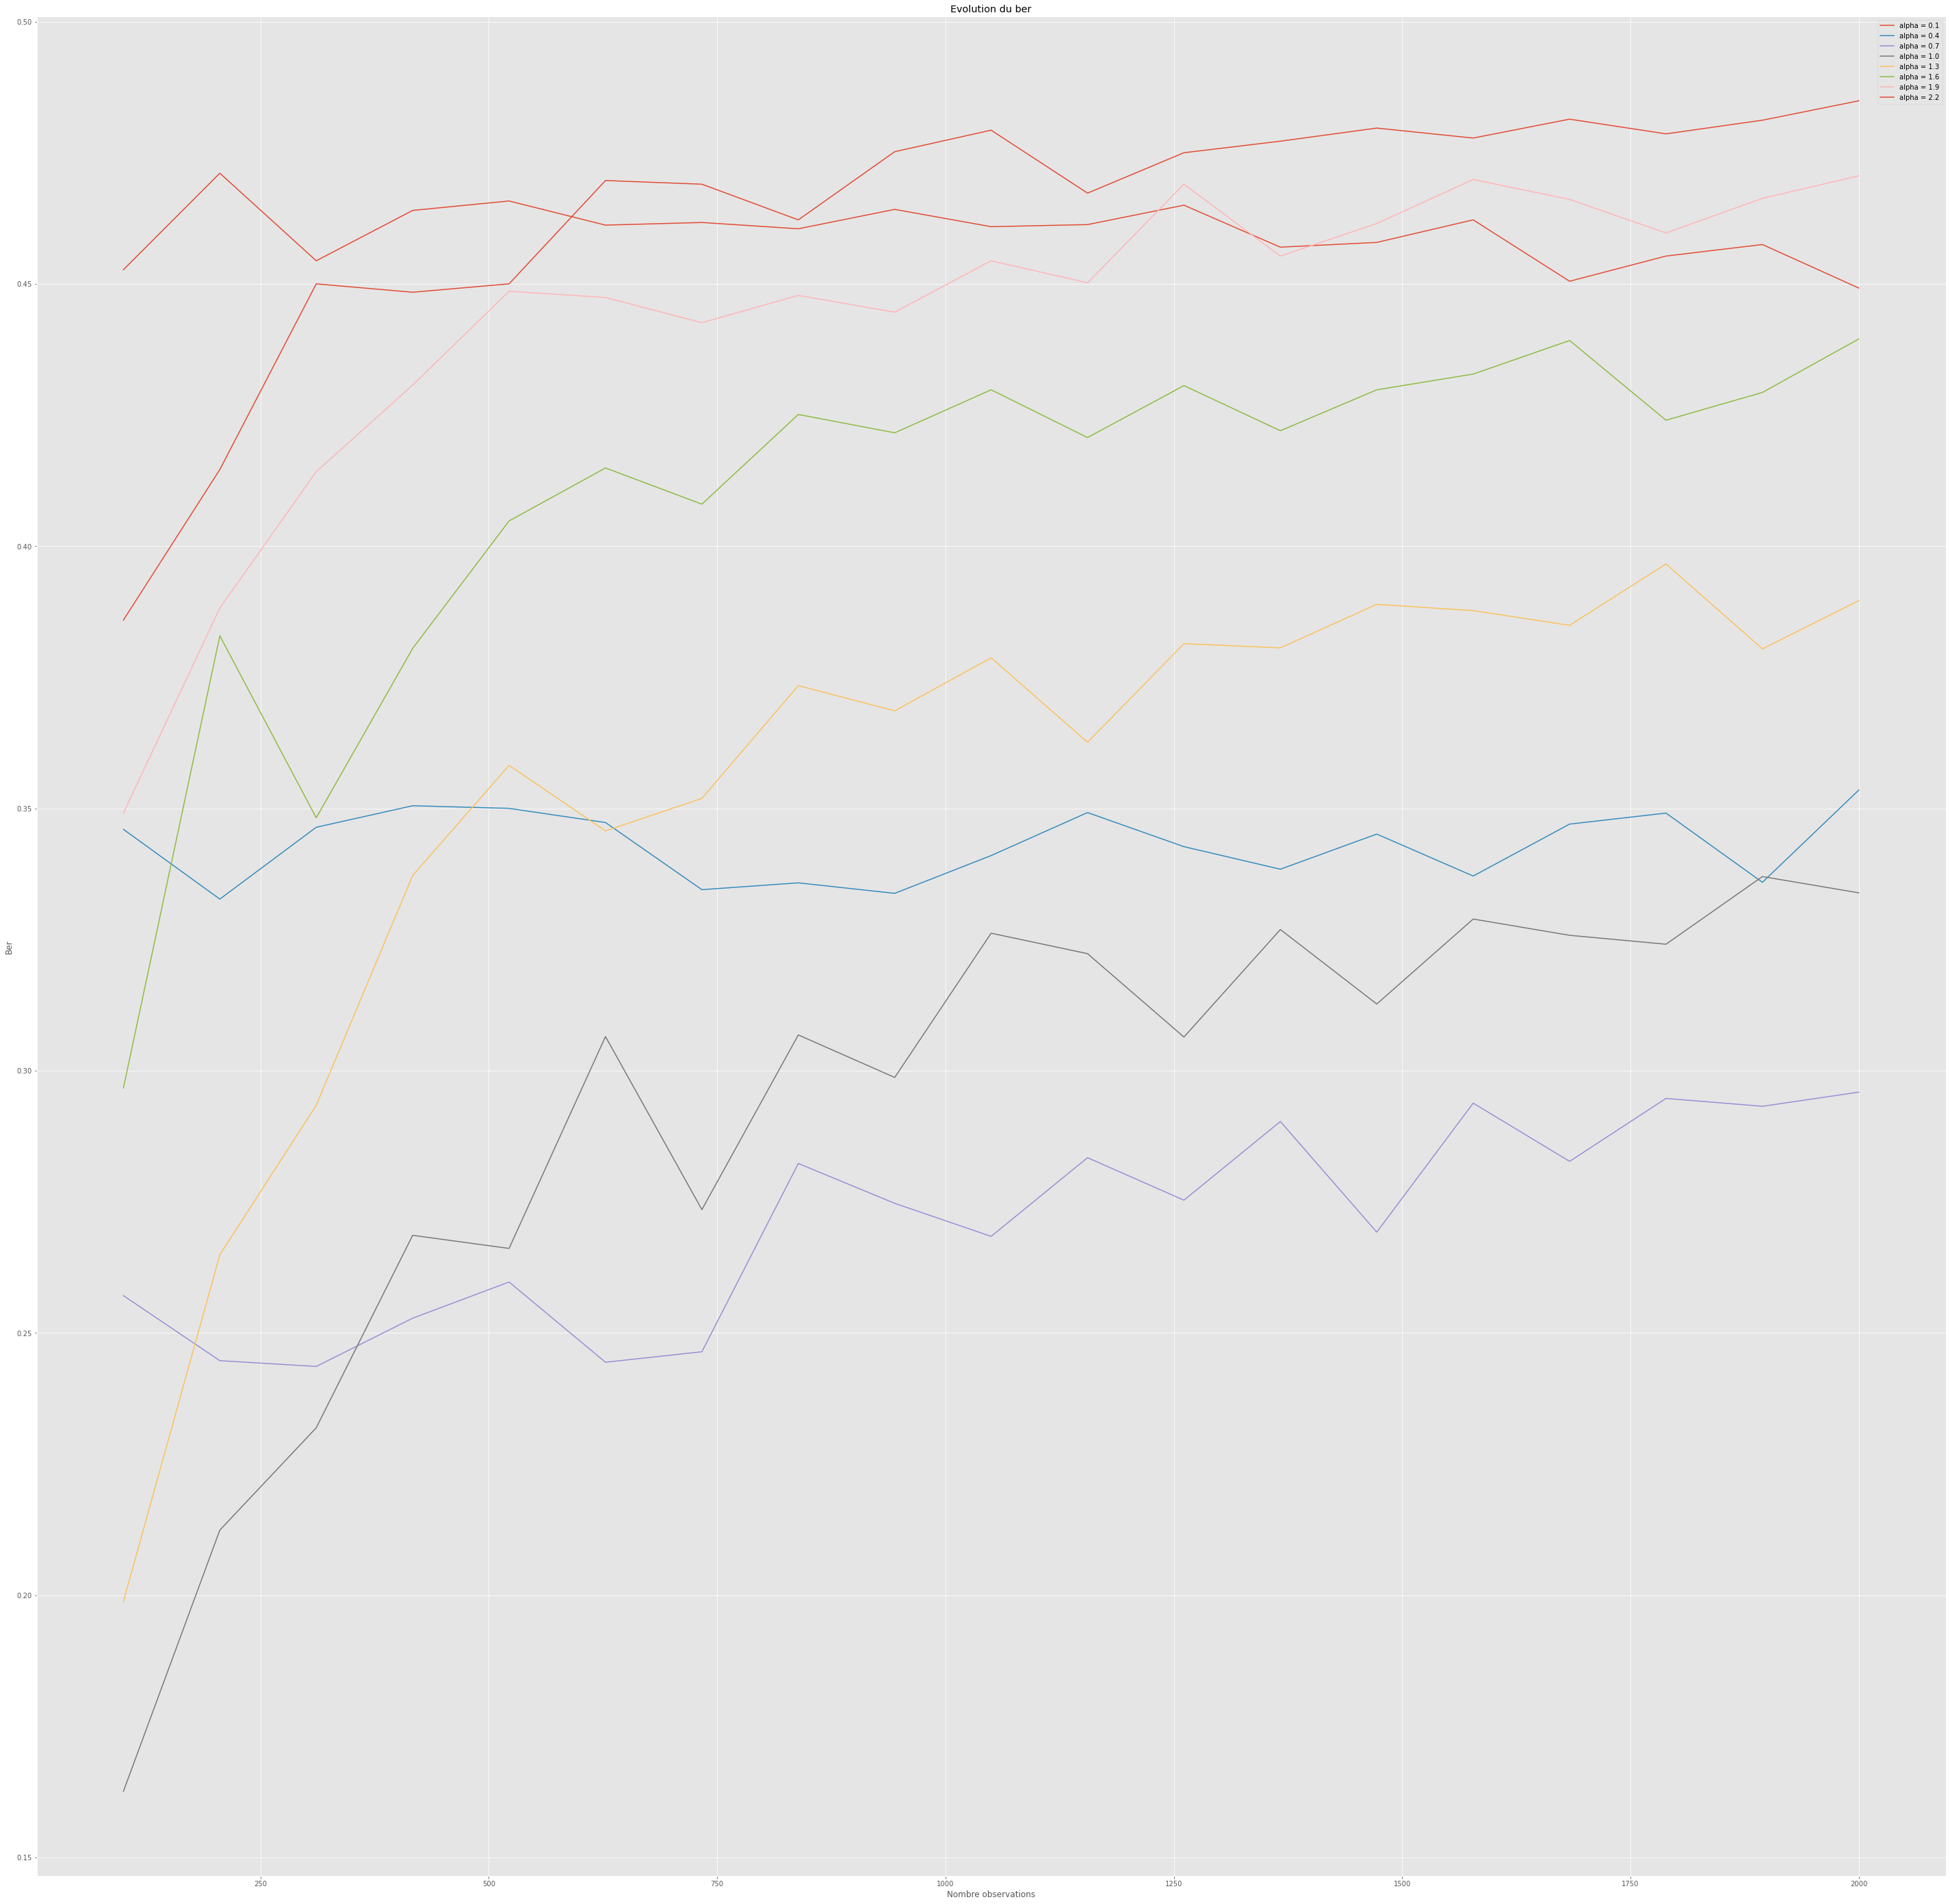

In [7]:
history_process_2(np.arange(0.1,2.3,0.3), 100,2000,100)

Nous constatons la même évolution selon le nombre d'observations.
Pour de grands alpha il est plus facile de détecter le message caché, pour un alpha faible, le Ber est d'autant plus éloigné de 0.5 car l'analyse en composantes principales n'est pas assez précise pour séparer les points en deux groupes puisqu'ils sont parfois confondus.

## Scénario 3: Attaque à messages inconnus, 2 bits
* Vérifier que l'attaque précédente ne permet pas d'estimer les deux clés. 
* Estimer au moins l'une des clés utilisée
    * Note: on pourra utiliser l'algorithme `FastICA` pour estimer les deux composantes indépendantes 
    * Pour cela on pourra appeler la fonction fastica en spécifiant que l'analyse en composantes indépendantes s'effectuera sur un sous espace engendré par les *deux premières composantes principales* (`n_components=2`), et en récupérant les colonnes de la matrice de mélange A (obtenue via `ica.mixing_`) estimé par l'algorithme.
    * Vérifier, à l'aide de la corrélation normalisée, que cette méthode permet d'estimer la clé `k1`
* Mettre en place l'attaque qui permet d'effacter un bit sur les deux
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

In [152]:
# 3rd scenario, 2 bits
print('3rd scenario, 2bits')

m1 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, first bit
m2 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, second bit

k1 = np.random.randn(Nv,1) # Generate de Watermark
k1 = k1 / np.sqrt(np.dot(k1.T,k1)) # Normalize the watermark

k2 = np.random.randn(Nv,1) # Generate de Watermark
k2 = k2 / np.sqrt(np.dot(k2.T,k2)) # Normalize the watermark

def do_process_3(alpha,No):
    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors

    K = np.dot(k1,m1.T) + np.dot(k2,m2.T) # Generate the matrix of watermarks (each column contains m1_i*k)

    W = alpha*K

    Y = X + W # perform embedding
    Y1 = X + alpha*np.dot(k1,m1.T)
    Y2 = X + alpha*np.dot(k2,m2.T)
    Y_obs = Y[:,:No]
    # TO DO
    transformer = FastICA(n_components=2,random_state=0,whiten='unit-variance')
    transformer.fit(Y_obs.T) # shape  : (100 = Nv , 2=n_components)
    A = transformer.mixing_
    # hatk_1 = TO DO
    hatk_1 = A[:,0] 
    hatk_1.reshape(-1, 1)
    hatk_1 = hatk_1/np.linalg.norm(hatk_1)
    
    hatk_2 = A[:,1] 
    hatk_2.reshape(-1, 1)
    hatk_2 = hatk_2/np.linalg.norm(hatk_2)

    corrN_1 = max(norm_corr(hatk_1,k1), norm_corr(hatk_1,k2)) # Compute the Normalised correlation
    corrN_2 = max(norm_corr(hatk_2,k2),norm_corr(hatk_2,k2))
    #print('Normalised correlation between the estimated key and k1')
    #print(corrN_1)

    
    # Perform the attack
    # To do

    m_est_1 = (np.sign(Y.T@hatk_1))
    YA_1 = Y - alpha*(hatk_1[np.newaxis].T@m_est_1[np.newaxis])

    m_est_2 = (np.sign(Y.T@hatk_2))
    YA_2 = Y - alpha*(hatk_2[np.newaxis].T@m_est_2[np.newaxis])
    #YA_1 = np.zeros((Nv,Ni))# To change
    
    #print('bit error rate after security attack for the first bit')
    #print(ber(YA_1,m1,k1))
    #print('bit error rate after security attack for the second bit')
    #print(ber(YA_1,m2,k2))
    #print('\n\n')
    
    ber_1=min(ber(YA_1,m_est_1,k1), ber(YA_1,m_est_2,k1))
    ber_2=min(ber(YA_2,m_est_1,k2), ber(YA_2,m_est_1,k2))
    return ber_1,corrN_1, ber_2, corrN_2



alpha = 2 # Tune the power of the watermark here

def history_process_3(alpha, min_No, max_No, step, show=True):

    assert (max_No-min_No)%step == 0 , "erreur dans les paramètres"
    if (type(alpha)==int):
        plt.style.use('ggplot')
        plt.figure(figsize=(20,20))
        for a in range(1,alpha):
            historyCorr = []
            historyBer = []
            for No in range(min_No,max_No,step):
                ber_1,corr_1, _, _ = do_process_3(a,No)
                historyCorr.append(corr_1)
                historyBer.append(ber_1)
            if show :
                plt.plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyBer,label=f"alpha vaut : {a}")
        plt.title("Evolution du ber")
        plt.xlabel("Nombre observations")
        plt.ylabel("Ber")
        plt.legend()
        plt.show()
    else:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(50,50))
        for a in alpha:
            historyCorr = []
            historyBer = []
            for No in range(min_No,max_No,step):
                ber_1,corr_1, _, _= do_process_3(a,No)
                historyCorr.append(corr_1)
                historyBer.append(ber_1)
            if show :
                ax[0].set_title("Evolution du ber")
                ax[0].set_xlabel("Nombre d'observations")
                ax[0].set_ylabel("ber")
                
                ax[0].plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyBer, label = f"alpha = {round(a,1)}")
                ax[0].legend()
                ax[1].set_title("Évolution de la corrélation")
                ax[1].set_xlabel("Nombre d'observations")
                ax[1].set_ylabel("Corrélation")
                
                ax[1].plot(np.linspace(min_No,max_No,int((max_No-min_No)/step)),historyCorr, label = f"alpha = {round(a,1)}")
                ax[1].legend()
            
        plt.show()

3rd scenario, 2bits


c:\Apps\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


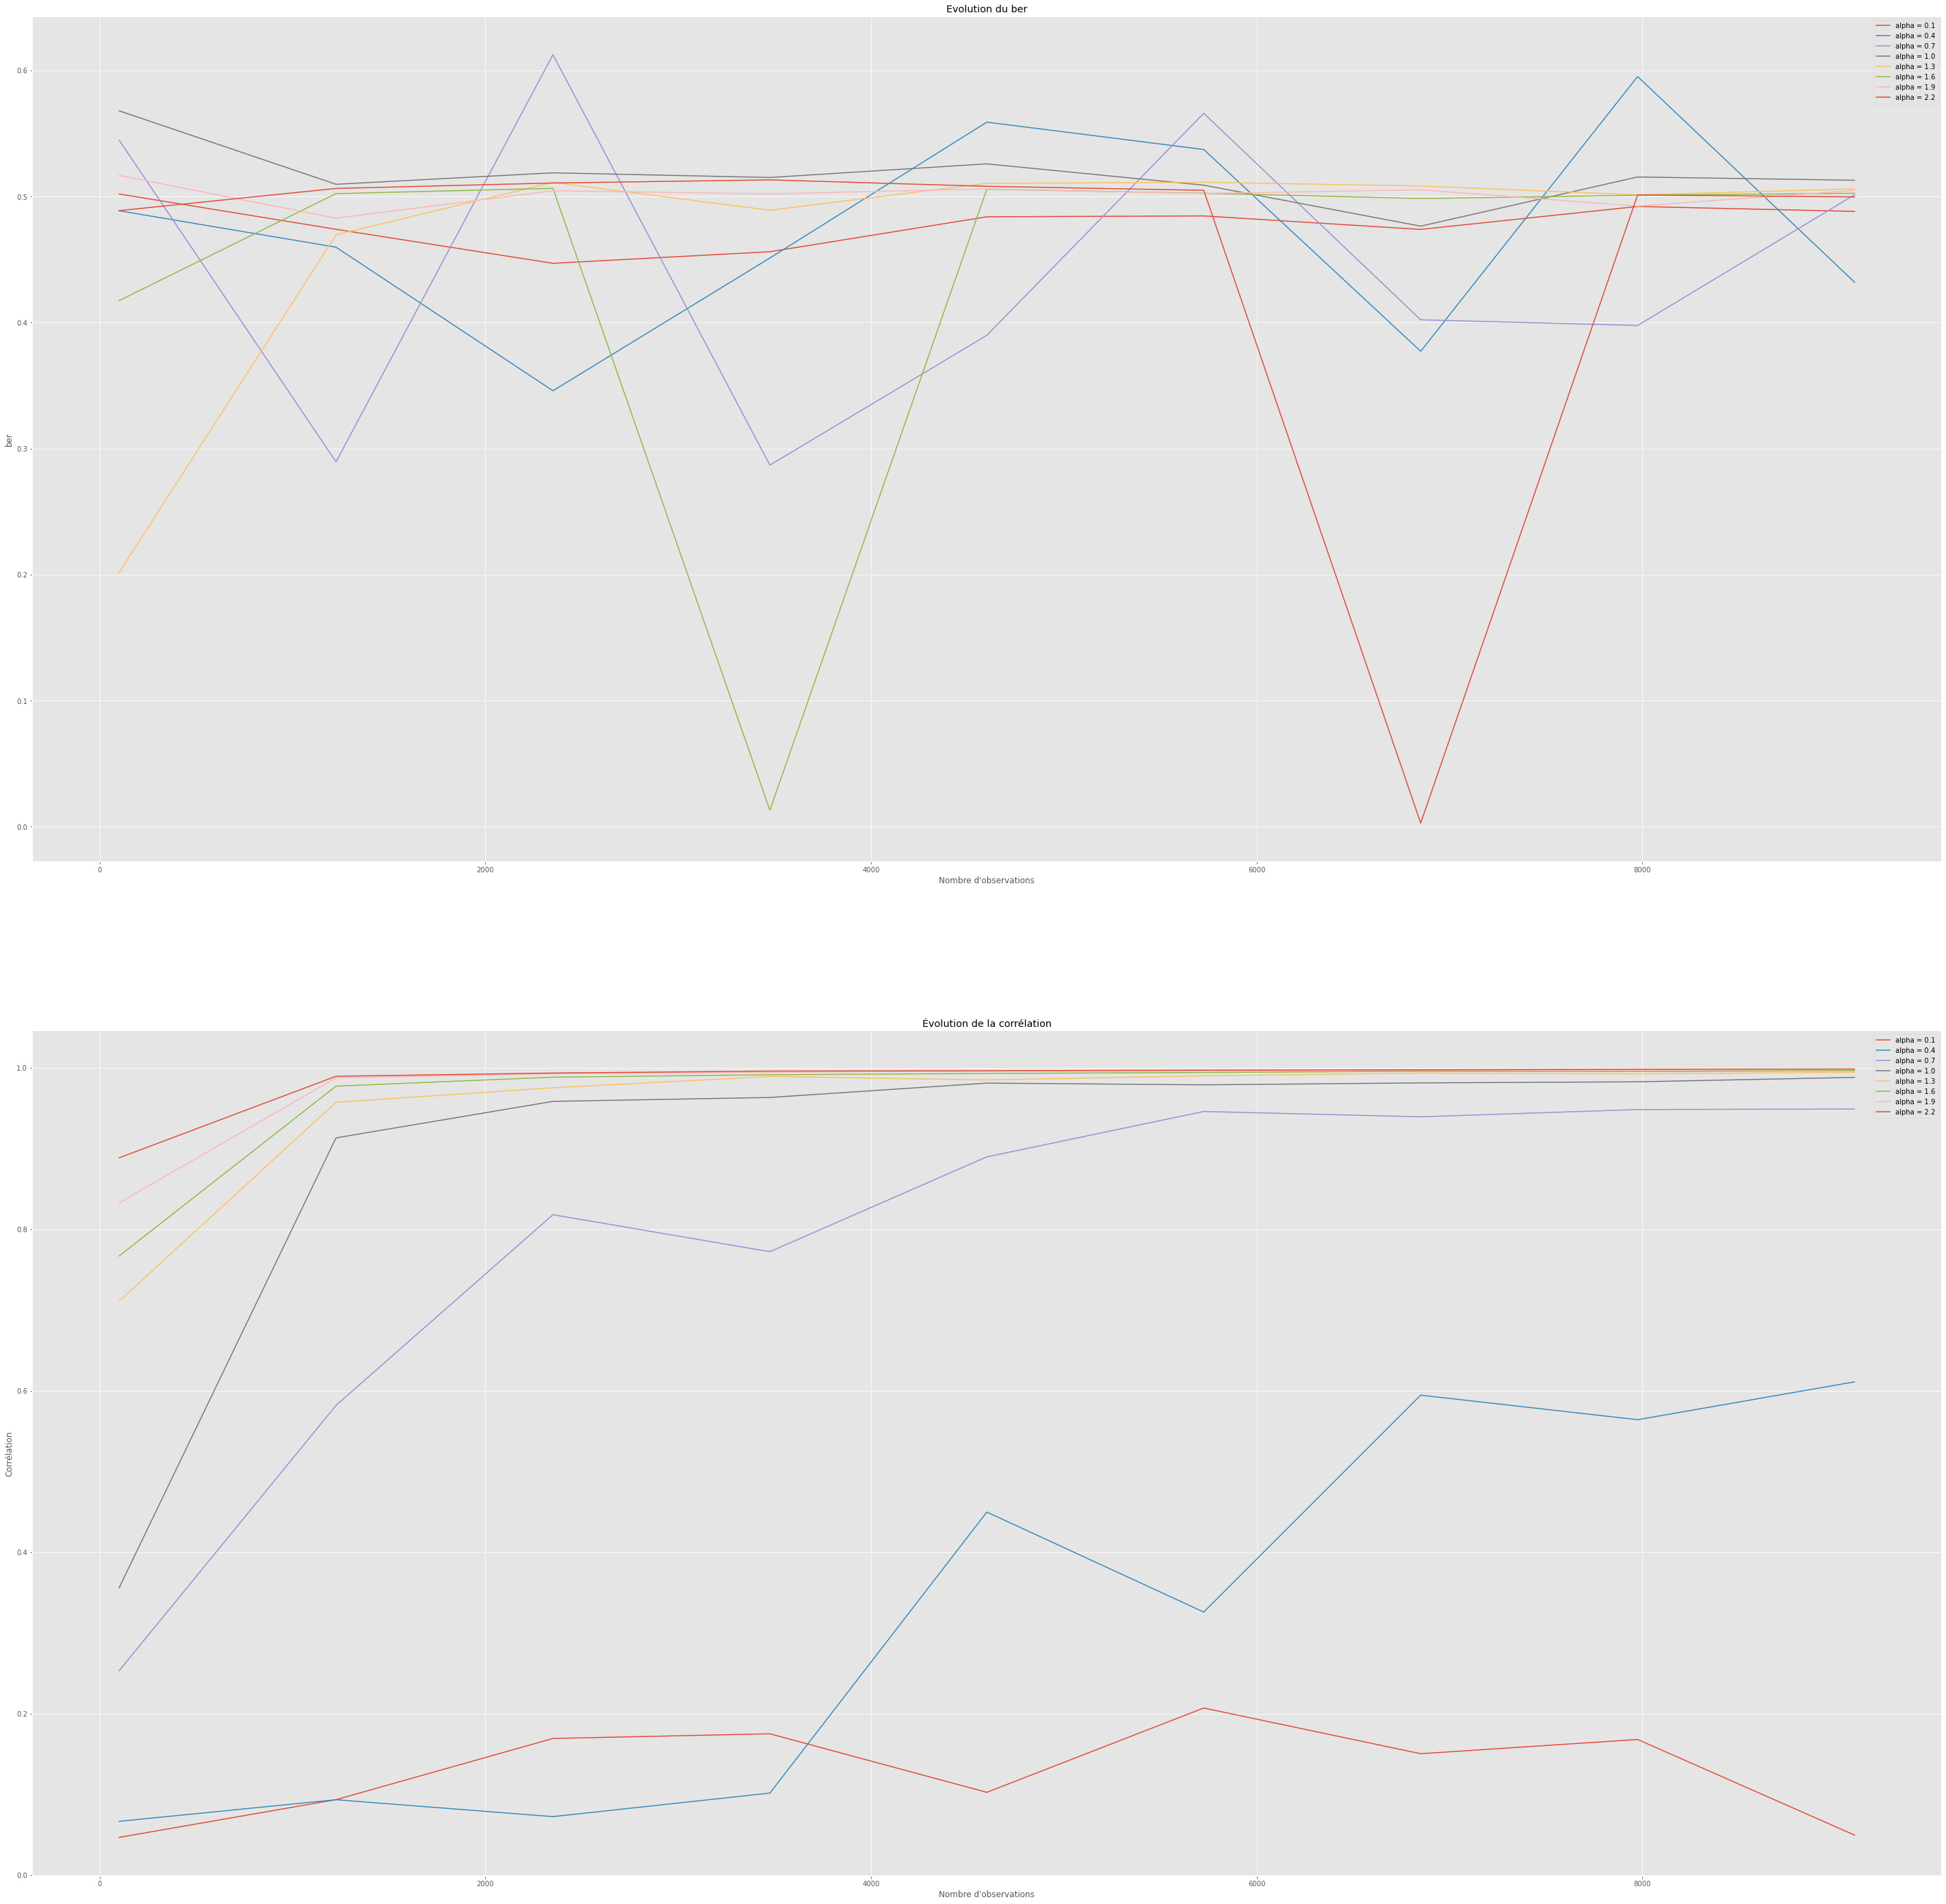

In [153]:
history_process_3(np.arange(0.1,2.3,0.3), 100,9100,1000)

## Pour conclure: Etude de la robustesse
* Calculer le taux d'erreur (BER pour Bit Error Rate) théorique après ajout de bruit (voir cours)
* Etudier l'évolution de la robustesse (via le BER) en fonction de la distortion (via le DWR) 
* Quel compromis observe-t-on entre la sécurité et la robustesse?


# Stéganalyse par apprentissage
## Mise en route:
* Récupèrer les caractéristiques ici: https://nextcloud.univ-lille.fr/index.php/s/i6xr4JykqAASapN
* On charge les caractéristiques extraites à partir des images Cover et Stego pour d=3 (dimension de l'histogramme multivarié) et T=3 (seuil)

In [39]:
cover_N_3_T_3 = np.loadtxt('Features/cover-spam-N=3-T=3.csv')
stego_N_3_T_3 = np.loadtxt('Features/stego-0.20-lsb-spam-N=3-T=3.csv')

cover_N_2_T_4 = np.loadtxt('Features/cover-spam-N=2-T=4.csv')
stego_N_2_T_4 = np.loadtxt('Features/stego-0.20-lsb-spam-N=2-T=4.csv')

**Quelle est la dimension des caractéristiques ? Pourquoi ?**

In [40]:
print(cover_N_3_T_3.shape)
print(stego_N_3_T_3.shape)
print(cover_N_2_T_4.shape)
print(stego_N_2_T_4.shape)

(10000, 686)
(10000, 686)
(10000, 162)
(10000, 162)


In [38]:
686**(1/2)

26.19160170741759

PCQ

In [37]:
cover

array([[0.2236553 , 0.28582351, 0.17887666, ..., 0.12373752, 0.25706438,
        0.29484038],
       [0.11255146, 0.14411591, 0.14742367, ..., 0.13324083, 0.13199809,
        0.10916368],
       [0.14581538, 0.18725662, 0.17065264, ..., 0.14426672, 0.17323481,
        0.15116081],
       ...,
       [0.05969731, 0.09427784, 0.10555525, ..., 0.09289848, 0.0594373 ,
        0.05161786],
       [0.04715302, 0.05035243, 0.05331439, ..., 0.07040138, 0.05057965,
        0.04284793],
       [0.07339053, 0.08997566, 0.09813261, ..., 0.10042559, 0.08471947,
        0.05994277]])

**Entrainer un classifieur linéaire avec 5000 images en apprentissage et en test (effectuer une permutation pseudo-aléatoire des images avant l'apprentissage)**

**Vérifier l'impact de l'apprentissage par paires**

**Effectuer plusieurs entrainements/test successifs sur des ensembles d'apprentissage et de test différents (permutations différentes), commentez la variabilité**

**Comparer avec les caractéristiques produites pour N = 2 et T = 4 (fournies), expliquer la différence de performance**